In [1]:
import json

In [2]:
# this file was obtained by looking for all .dcm files in the bucket
dir_name = 'dicoms.txt'
fnames = open(dir_name).readlines()
fnames = [fname.strip() for fname in fnames]

In [ ]:
# Get the first file from each directory; they are sorted.
seen_roots = set()
first_files = []
for fname in fnames:
    root = '/'.join(fname.split('/')[:-1])
    if not root in seen_roots:
        seen_roots.add(root)
        first_files.append(fname)

len(seen_roots), len(first_files)

In [ ]:
# Computing hash code per first file -- this can take 3 hours...
seen_hashes = {}

import hashlib
for fname in first_files:
    digest = hashlib.md5(open(fname,'rb').read()).hexdigest()
    seen_hashes.setdefault(digest, []).append(fname)

In [ ]:
len(seen_hashes)

In [ ]:
# test that there are some duplicates of predictable patterns
i = 0
for k, v in seen_hashes.items():
    if len(v) > 2:
        raise Exception("TOO MANY")
    if len(v) > 1:
        second = v[0].split('/')[1]
        ## only take dirs with NLST in the second component
        if 'NLST' not in second:
            continue
        ## those that have the same third component are duplicates
        third0 = v[0].split('/')[3]
        third1 = v[1].split('/')[3]
        if third0 == third1:
            continue
        print(k), print(v)
        if i > 20:
            break
        i += 1

# Take the last one from each paper to de-duplicate
deduped = []
for k, v in seen_hashes.items():
    deduped.append('/'.join(v[-1].split('/')[:-1]))
assert len(deduped) == len(seen_hashes)

In [40]:
# save into json
with open('nlst-dirs.json', 'w') as f:
    json.dump(deduped, f, indent=2, sort_keys=True)

In [1]:
# Experiments with saving/restoring of volumes restored from Dicom files

In [2]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt

def load_dicom_volume(directory):
    """
    Loads a 3D volume from a directory of DICOM files.
    
    Args:
        directory (str): Path to the directory containing DICOM files.

    Returns:
        np.ndarray: 3D volume reconstructed from the DICOM slices.
    """
    # List all DICOM files in the directory
    dicom_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    
    # Read all DICOM slices
    slices = [pydicom.dcmread(f) for f in dicom_files]
    
    # Sort slices by Instance Number or Slice Location
    slices.sort(key=lambda s: float(s.InstanceNumber))
    
    # Extract pixel data from each slice
    pixel_arrays = [s.pixel_array for s in slices]
    
    # Stack slices to form a 3D volume
    volume = np.stack(pixel_arrays, axis=-1)
    
    # # Get voxel spacing (if available in DICOM metadata)
    # try:
    #     pixel_spacing = slices[0].PixelSpacing  # Spacing in x and y
    #     slice_thickness = float(slices[0].SliceThickness)  # Spacing in z
    #     spacing = (*pixel_spacing, slice_thickness)
    #     print(f"Voxel Spacing: {spacing}")
    # except AttributeError:
    #     print("Voxel spacing not found in metadata.")
    
    return volume

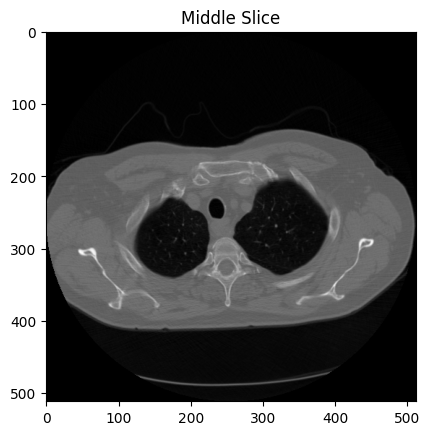

In [3]:
# Example Usage
dicom_dir = "nlst-bucket/manifest-1709246899312/NLST/100002/01-02-2000-NLST-LSS-11765/1.000000-1OPAGELSPLUSD3602.512080.00.11.5-72875"
dicom_dir = "nlst-bucket/manifest-1709246899312/NLST/100004/01-02-2000-NLST-LSS-74562/1.000000-1OPAGELSPLUSD4102.512080.00.11.5-69408"
volume = load_dicom_volume(dicom_dir)

# Visualize a slice from the volume
plt.imshow(volume[:, :, volume.shape[2] // 2], cmap='gray')
plt.title("Middle Slice")
plt.show()

In [4]:
def save_volume_as_npz(volume, output_path):
    """
    Saves a 3D volume as a compressed NumPy array.
    
    Args:
        volume (np.ndarray): 3D volume to save.
        output_path (str): Path to save the .npz file.
    """
    np.savez_compressed(output_path, volume=volume)
    print(f"Volume saved as a compressed NumPy array at: {output_path}")

save_volume_as_npz(volume, 'temp.npz')

loaded_data = np.load('temp.npz')
volume = loaded_data['volume']

# Verify the shape
print(f"Loaded volume shape: {volume.shape}")

volume.max(), volume.min(), volume.dtype

Volume saved as a compressed NumPy array at: temp.npz
Loaded volume shape: (512, 512, 29)


(2792, 0, dtype('uint16'))

In [5]:
import zarr

import numcodecs

compressor = zarr.Zlib(level=5) # not so good, on par with npz
# compressor = numcodecs.LZMA(preset=6)  # slow but as good as Blosc
compressor = numcodecs.Blosc(cname='zstd', clevel=5, shuffle=numcodecs.Blosc.SHUFFLE) ## fastest and 1:3 ratio.

def save_with_zarr(array, output_path, compressor=compressor):
    z = zarr.open(output_path, mode='w', shape=array.shape, dtype=array.dtype, compressor=compressor)
    z[:] = array
    print(f"Array saved using Zarr at: {output_path}")

def load_with_zarr(input_path):
    z = zarr.open(input_path, mode='r')
    return z[:]

# Example Usage
output_file = "temp.zarr"
save_with_zarr(volume, output_file)

loaded_volume = load_with_zarr(output_file)
print(f"Loaded volume shape: {loaded_volume.shape}")

Array saved using Zarr at: temp.zarr
Loaded volume shape: (512, 512, 29)


In [6]:
import h5py

# Slow and not so good

def save_with_h5py(array, output_path, compression="gzip", level=9):
    with h5py.File(output_path, 'w') as f:
        f.create_dataset('volume', data=array, compression=compression, compression_opts=level)
    print(f"Array saved using HDF5 at: {output_path}")

def load_with_h5py(input_path):
    with h5py.File(input_path, 'r') as f:
        array = f['volume'][:]
    return array

# Example Usage
output_file = "volume.h5"
save_with_h5py(volume, output_file)
loaded_volume = load_with_h5py(output_file)
print(f"Loaded volume shape: {loaded_volume.shape}")

Array saved using HDF5 at: volume.h5
Loaded volume shape: (512, 512, 29)
